# Import Libraries

In [1]:
import datetime
print("Model execution started at:" + datetime.datetime.today().ctime())

Model execution started at:Sun Mar 22 23:14:40 2020


In [2]:
import src.dataset.dataset as dst
import src.dataset.dataloader as dl
import src.preprocessing.albumentationstransforms as preprocessing
import src.utils.utils as utils
import src.models.train_model as train
import src.visualization.plotdata as plotdata
import src.preprocessing.customcompose as customcompose
from src.train.lrfinder.lrfinder import LRFinder
import src.train.train_model
%config IPCompleter.greedy=True
%reload_ext autoreload


In [3]:
%autoreload 2  # Autoreload all modules

In [4]:
def printgpuinfo():
    gpu_info = !nvidia-smi
    gpu_info = '\n'.join(gpu_info)
    if gpu_info.find('failed') >= 0:
      print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
      print('and then re-execute this cell.')
    else:
      print(gpu_info)

In [5]:
def showsysteminfo():
    from psutil import virtual_memory
    ram_gb = virtual_memory().total / 1e9
    print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

    if ram_gb < 20:
      print('To enable a high-RAM runtime, select the Runtime → "Change runtime type"')
      print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
      print('re-execute this cell.')
    else:
      print('You are using a high-RAM runtime!')

In [6]:
import torch
print(torch.__version__)

1.4.0


In [7]:
# mean,std= utils.Utils.calculatemeanandstddeviation()
# print("mean: " + str(mean))
# print("std: " + str(std))
mean=[0.5,0.5,0.5]
std=[0.5,0.5,0.5]
preproc = preprocessing.AlbumentaionsTransforms()
train_transforms = preproc.gettraintransforms(mean,std)
test_transforms = preproc.gettesttransforms(mean,std)
compose_train = customcompose.CustomCompose(train_transforms)
compose_test = customcompose.CustomCompose(test_transforms)

In [8]:
ds = dst.Dataset()
train_dataset = ds.gettraindataset(compose_train)
test_dataset = ds.gettestdataset(compose_test)

Files already downloaded and verified
Files already downloaded and verified


In [9]:
batch_size = 128
dataloader = dl.Cifar10Dataloader(traindataset=train_dataset, testdataset=test_dataset,batch_size=batch_size)
train_loader = dataloader.gettraindataloader()
test_loader = dataloader.gettestdataloader()

CUDA Available? True
128


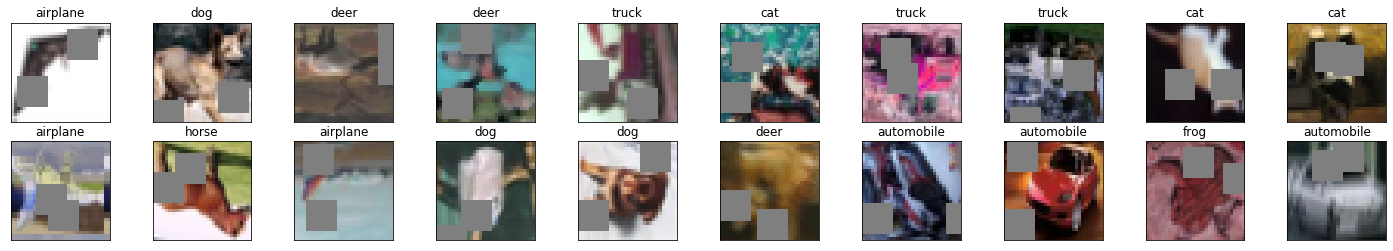

In [10]:
# specify the image classes
classes = ds.getclassesinCIFAR10dataset()

#TODO show transformed images fom dataset
dataiterator = iter(train_loader)
plotdata.PlotData.showImagesfromdataset(dataiterator,classes=classes)

In [11]:
cnn_model, device = utils.Utils.createmodelresnet18()
train_model = train.TrainModel()
train_model.showmodelsummary(cnn_model)

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1,

In [12]:
optimizer = utils.Utils.createoptimizer(cnn_model, lr=0.06, momentum=0.9, weight_decay=0, nesterov=True)
criterion = torch.nn.CrossEntropyLoss()

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


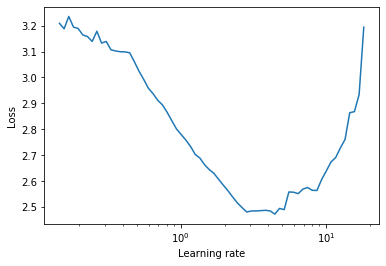

In [13]:
lr_finder = LRFinder(cnn_model, optimizer, criterion, device="cuda")
lr_finder.range_test(train_loader, end_lr=100, num_iter=100, step_mode="exp")
lr_finder.plot()

In [14]:
lr_finder.reset()

In [15]:
lr_finder.range_test(train_loader, val_loader=test_loader, end_lr=100, num_iter=100, step_mode="exp")

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


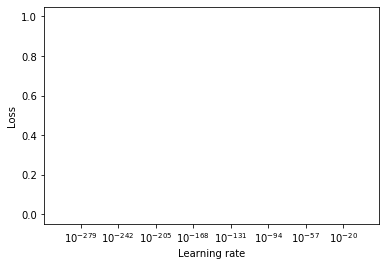

In [16]:
lr_finder.plot(skip_end=0)

In [17]:
lr_finder.reset()

In [18]:
optimizer = utils.Utils.createoptimizer(cnn_model, lr=0.06, momentum=0.9, weight_decay=0, nesterov=True)
scheduler = utils.Utils.createscheduler(optimizer, mode='max', factor=0.9, patience=2,
                                        verbose=True)

In [19]:
lr_data = []
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
epochs = 50
for epoch in range(1, epochs+1):
    print("EPOCH:", epoch)
    train_model.train(cnn_model, device, train_loader, optimizer, 1)
    t_acc_epoch = train_model.test(cnn_model, device, test_loader, class_correct=class_correct,
                                   class_total=class_total, epoch=epoch)
    scheduler.step(t_acc_epoch)
    for param_groups in optimizer.param_groups:
        print("Learning rate =", param_groups['lr'], " for epoch: ", epoch + 1)  # print LR for different epochs
        lr_data.append(param_groups['lr'])

  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH: 1


/home/abhijit/.virtualenvs/dl4cv/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
Loss=1.6379382610321045 Batch_id=390 Accuracy=26.58: 100%|██████████| 391/391 [02:23<00:00,  2.72it/s]



Test set: Average loss: 0.0132, Accuracy: 3805/10000 (38.05%)

Validation accuracy increased (0.000000 --> 38.050000).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

Learning rate = 0.06  for epoch:  2
EPOCH: 2


Loss=1.7005037069320679 Batch_id=390 Accuracy=37.15: 100%|██████████| 391/391 [02:35<00:00,  2.51it/s]



Test set: Average loss: 0.0129, Accuracy: 4216/10000 (42.16%)

Validation accuracy increased (38.050000 --> 42.160000).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

Learning rate = 0.06  for epoch:  3
EPOCH: 3


Loss=1.4637397527694702 Batch_id=390 Accuracy=41.95: 100%|██████████| 391/391 [02:38<00:00,  2.47it/s]



Test set: Average loss: 0.0109, Accuracy: 5031/10000 (50.31%)

Validation accuracy increased (42.160000 --> 50.310000).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

Learning rate = 0.06  for epoch:  4
EPOCH: 4


Loss=1.591672420501709 Batch_id=390 Accuracy=45.12: 100%|██████████| 391/391 [02:36<00:00,  2.50it/s] 



Test set: Average loss: 0.0107, Accuracy: 5153/10000 (51.53%)

Validation accuracy increased (50.310000 --> 51.530000).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

Learning rate = 0.06  for epoch:  5
EPOCH: 5


Loss=1.5955723524093628 Batch_id=390 Accuracy=48.13: 100%|██████████| 391/391 [02:37<00:00,  2.48it/s]



Test set: Average loss: 0.0106, Accuracy: 5335/10000 (53.35%)

Validation accuracy increased (51.530000 --> 53.350000).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

Learning rate = 0.06  for epoch:  6
EPOCH: 6


Loss=1.4292194843292236 Batch_id=390 Accuracy=50.93: 100%|██████████| 391/391 [02:46<00:00,  2.35it/s]



Test set: Average loss: 0.0089, Accuracy: 6019/10000 (60.19%)

Validation accuracy increased (53.350000 --> 60.190000).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

Learning rate = 0.06  for epoch:  7
EPOCH: 7


Loss=1.366280198097229 Batch_id=390 Accuracy=53.21: 100%|██████████| 391/391 [03:00<00:00,  2.17it/s] 



Test set: Average loss: 0.0086, Accuracy: 6180/10000 (61.80%)

Validation accuracy increased (60.190000 --> 61.800000).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

Learning rate = 0.06  for epoch:  8
EPOCH: 8


Loss=1.4597892761230469 Batch_id=390 Accuracy=55.34: 100%|██████████| 391/391 [02:46<00:00,  2.35it/s]



Test set: Average loss: 0.0084, Accuracy: 6261/10000 (62.61%)

Validation accuracy increased (61.800000 --> 62.610000).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

Learning rate = 0.06  for epoch:  9
EPOCH: 9


Loss=1.1720187664031982 Batch_id=390 Accuracy=57.19: 100%|██████████| 391/391 [02:43<00:00,  2.39it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0090, Accuracy: 5932/10000 (59.32%)

Learning rate = 0.06  for epoch:  10
EPOCH: 10


Loss=1.043071985244751 Batch_id=390 Accuracy=58.91: 100%|██████████| 391/391 [02:48<00:00,  2.32it/s] 



Test set: Average loss: 0.0075, Accuracy: 6675/10000 (66.75%)

Validation accuracy increased (62.610000 --> 66.750000).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

Learning rate = 0.06  for epoch:  11
EPOCH: 11


Loss=1.357799768447876 Batch_id=390 Accuracy=60.10: 100%|██████████| 391/391 [02:46<00:00,  2.34it/s] 



Test set: Average loss: 0.0072, Accuracy: 6828/10000 (68.28%)

Validation accuracy increased (66.750000 --> 68.280000).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

Learning rate = 0.06  for epoch:  12
EPOCH: 12


Loss=1.0084888935089111 Batch_id=390 Accuracy=61.66: 100%|██████████| 391/391 [02:45<00:00,  2.36it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0077, Accuracy: 6616/10000 (66.16%)

Learning rate = 0.06  for epoch:  13
EPOCH: 13


Loss=0.9363706707954407 Batch_id=390 Accuracy=62.64: 100%|██████████| 391/391 [02:47<00:00,  2.34it/s]



Test set: Average loss: 0.0063, Accuracy: 7200/10000 (72.00%)

Validation accuracy increased (68.280000 --> 72.000000).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

Learning rate = 0.06  for epoch:  14
EPOCH: 14


Loss=0.8528590202331543 Batch_id=390 Accuracy=64.09: 100%|██████████| 391/391 [02:41<00:00,  2.42it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0067, Accuracy: 7012/10000 (70.12%)

Learning rate = 0.06  for epoch:  15
EPOCH: 15


Loss=1.092162847518921 Batch_id=390 Accuracy=65.42: 100%|██████████| 391/391 [02:41<00:00,  2.43it/s] 



Test set: Average loss: 0.0060, Accuracy: 7318/10000 (73.18%)

Validation accuracy increased (72.000000 --> 73.180000).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

Learning rate = 0.06  for epoch:  16
EPOCH: 16


Loss=0.8577710390090942 Batch_id=390 Accuracy=66.38: 100%|██████████| 391/391 [02:40<00:00,  2.43it/s]



Test set: Average loss: 0.0057, Accuracy: 7488/10000 (74.88%)

Validation accuracy increased (73.180000 --> 74.880000).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

Learning rate = 0.06  for epoch:  17
EPOCH: 17


Loss=0.8002433776855469 Batch_id=390 Accuracy=67.26: 100%|██████████| 391/391 [02:38<00:00,  2.47it/s]



Test set: Average loss: 0.0055, Accuracy: 7662/10000 (76.62%)

Validation accuracy increased (74.880000 --> 76.620000).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

Learning rate = 0.06  for epoch:  18
EPOCH: 18


Loss=1.0126440525054932 Batch_id=390 Accuracy=68.82: 100%|██████████| 391/391 [02:36<00:00,  2.50it/s]



Test set: Average loss: 0.0051, Accuracy: 7728/10000 (77.28%)

Validation accuracy increased (76.620000 --> 77.280000).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

Learning rate = 0.06  for epoch:  19
EPOCH: 19


Loss=0.8699685335159302 Batch_id=390 Accuracy=69.45: 100%|██████████| 391/391 [01:55<00:00,  3.39it/s]



Test set: Average loss: 0.0051, Accuracy: 7781/10000 (77.81%)

Validation accuracy increased (77.280000 --> 77.810000).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

Learning rate = 0.06  for epoch:  20
EPOCH: 20


Loss=0.733279287815094 Batch_id=390 Accuracy=70.04: 100%|██████████| 391/391 [02:01<00:00,  3.21it/s] 



Test set: Average loss: 0.0048, Accuracy: 7890/10000 (78.90%)

Validation accuracy increased (77.810000 --> 78.900000).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

Learning rate = 0.06  for epoch:  21
EPOCH: 21


Loss=0.8595634698867798 Batch_id=390 Accuracy=71.18: 100%|██████████| 391/391 [02:27<00:00,  2.65it/s]



Test set: Average loss: 0.0048, Accuracy: 7911/10000 (79.11%)

Validation accuracy increased (78.900000 --> 79.110000).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

Learning rate = 0.06  for epoch:  22
EPOCH: 22


Loss=1.0088672637939453 Batch_id=390 Accuracy=71.72: 100%|██████████| 391/391 [02:24<00:00,  2.71it/s]



Test set: Average loss: 0.0045, Accuracy: 8058/10000 (80.58%)

Validation accuracy increased (79.110000 --> 80.580000).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

Learning rate = 0.06  for epoch:  23
EPOCH: 23


Loss=0.8515594601631165 Batch_id=390 Accuracy=72.29: 100%|██████████| 391/391 [02:26<00:00,  2.68it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0045, Accuracy: 8031/10000 (80.31%)

Learning rate = 0.06  for epoch:  24
EPOCH: 24


Loss=0.5715652704238892 Batch_id=390 Accuracy=72.92: 100%|██████████| 391/391 [02:28<00:00,  2.64it/s]



Test set: Average loss: 0.0044, Accuracy: 8142/10000 (81.42%)

Validation accuracy increased (80.580000 --> 81.420000).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

Learning rate = 0.06  for epoch:  25
EPOCH: 25


Loss=0.7122853994369507 Batch_id=390 Accuracy=73.51: 100%|██████████| 391/391 [02:26<00:00,  2.66it/s]



Test set: Average loss: 0.0042, Accuracy: 8215/10000 (82.15%)

Validation accuracy increased (81.420000 --> 82.150000).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

Learning rate = 0.06  for epoch:  26
EPOCH: 26


Loss=0.6714614033699036 Batch_id=390 Accuracy=74.34: 100%|██████████| 391/391 [02:24<00:00,  2.70it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0044, Accuracy: 8110/10000 (81.10%)

Learning rate = 0.06  for epoch:  27
EPOCH: 27


Loss=0.7086911201477051 Batch_id=390 Accuracy=74.84: 100%|██████████| 391/391 [02:26<00:00,  2.68it/s]



Test set: Average loss: 0.0040, Accuracy: 8257/10000 (82.57%)

Validation accuracy increased (82.150000 --> 82.570000).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

Learning rate = 0.06  for epoch:  28
EPOCH: 28


Loss=0.8204985857009888 Batch_id=390 Accuracy=75.13: 100%|██████████| 391/391 [02:25<00:00,  2.70it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0042, Accuracy: 8201/10000 (82.01%)

Learning rate = 0.06  for epoch:  29
EPOCH: 29


Loss=0.5278523564338684 Batch_id=390 Accuracy=75.62: 100%|██████████| 391/391 [02:25<00:00,  2.68it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0042, Accuracy: 8218/10000 (82.18%)

Learning rate = 0.06  for epoch:  30
EPOCH: 30


Loss=0.5980211496353149 Batch_id=390 Accuracy=76.14: 100%|██████████| 391/391 [02:20<00:00,  2.78it/s] 



Test set: Average loss: 0.0039, Accuracy: 8325/10000 (83.25%)

Validation accuracy increased (82.570000 --> 83.250000).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch    30: reducing learning rate of group 0 to 5.4000e-02.
Learning rate = 0.054  for epoch:  31
EPOCH: 31


Loss=0.59785395860672 Batch_id=390 Accuracy=76.92: 100%|██████████| 391/391 [02:22<00:00,  2.74it/s]   



Test set: Average loss: 0.0039, Accuracy: 8409/10000 (84.09%)

Validation accuracy increased (83.250000 --> 84.090000).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

Learning rate = 0.054  for epoch:  32
EPOCH: 32


Loss=0.6836111545562744 Batch_id=390 Accuracy=77.33: 100%|██████████| 391/391 [02:23<00:00,  2.73it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0039, Accuracy: 8327/10000 (83.27%)

Learning rate = 0.054  for epoch:  33
EPOCH: 33


Loss=0.6427431702613831 Batch_id=390 Accuracy=77.93: 100%|██████████| 391/391 [02:24<00:00,  2.71it/s] 



Test set: Average loss: 0.0036, Accuracy: 8469/10000 (84.69%)

Validation accuracy increased (84.090000 --> 84.690000).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

Learning rate = 0.054  for epoch:  34
EPOCH: 34


Loss=0.5463863015174866 Batch_id=390 Accuracy=78.12: 100%|██████████| 391/391 [02:16<00:00,  2.86it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0039, Accuracy: 8366/10000 (83.66%)

Epoch    34: reducing learning rate of group 0 to 4.8600e-02.
Learning rate = 0.0486  for epoch:  35
EPOCH: 35


Loss=0.6175686120986938 Batch_id=390 Accuracy=78.96: 100%|██████████| 391/391 [02:21<00:00,  2.76it/s] 



Test set: Average loss: 0.0036, Accuracy: 8480/10000 (84.80%)

Validation accuracy increased (84.690000 --> 84.800000).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

Learning rate = 0.0486  for epoch:  36
EPOCH: 36


Loss=0.8146455883979797 Batch_id=390 Accuracy=79.18: 100%|██████████| 391/391 [02:18<00:00,  2.82it/s] 



Test set: Average loss: 0.0036, Accuracy: 8485/10000 (84.85%)

Validation accuracy increased (84.800000 --> 84.850000).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

Learning rate = 0.0486  for epoch:  37
EPOCH: 37


Loss=0.4637684226036072 Batch_id=390 Accuracy=79.89: 100%|██████████| 391/391 [02:16<00:00,  2.86it/s] 



Test set: Average loss: 0.0033, Accuracy: 8589/10000 (85.89%)

Validation accuracy increased (84.850000 --> 85.890000).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

Learning rate = 0.0486  for epoch:  38
EPOCH: 38


Loss=0.5514726042747498 Batch_id=390 Accuracy=80.14: 100%|██████████| 391/391 [02:21<00:00,  2.76it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0035, Accuracy: 8539/10000 (85.39%)

Learning rate = 0.0486  for epoch:  39
EPOCH: 39


Loss=0.6457379460334778 Batch_id=390 Accuracy=80.31: 100%|██████████| 391/391 [02:38<00:00,  2.47it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0034, Accuracy: 8524/10000 (85.24%)

Learning rate = 0.0486  for epoch:  40
EPOCH: 40


Loss=0.5114356279373169 Batch_id=390 Accuracy=80.36: 100%|██████████| 391/391 [02:39<00:00,  2.45it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0033, Accuracy: 8574/10000 (85.74%)

Epoch    40: reducing learning rate of group 0 to 4.3740e-02.
Learning rate = 0.04374  for epoch:  41
EPOCH: 41


Loss=0.4455399513244629 Batch_id=390 Accuracy=81.38: 100%|██████████| 391/391 [02:41<00:00,  2.42it/s] 



Test set: Average loss: 0.0033, Accuracy: 8623/10000 (86.23%)

Validation accuracy increased (85.890000 --> 86.230000).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

Learning rate = 0.04374  for epoch:  42
EPOCH: 42


Loss=0.5840505957603455 Batch_id=390 Accuracy=81.58: 100%|██████████| 391/391 [02:43<00:00,  2.40it/s] 



Test set: Average loss: 0.0033, Accuracy: 8628/10000 (86.28%)

Validation accuracy increased (86.230000 --> 86.280000).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

Learning rate = 0.04374  for epoch:  43
EPOCH: 43


Loss=0.46992939710617065 Batch_id=390 Accuracy=81.90: 100%|██████████| 391/391 [02:42<00:00,  2.41it/s]



Test set: Average loss: 0.0033, Accuracy: 8640/10000 (86.40%)

Validation accuracy increased (86.280000 --> 86.400000).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch    43: reducing learning rate of group 0 to 3.9366e-02.
Learning rate = 0.039366000000000005  for epoch:  44
EPOCH: 44


Loss=0.4686582088470459 Batch_id=390 Accuracy=82.14: 100%|██████████| 391/391 [02:42<00:00,  2.41it/s] 



Test set: Average loss: 0.0032, Accuracy: 8700/10000 (87.00%)

Validation accuracy increased (86.400000 --> 87.000000).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

Learning rate = 0.039366000000000005  for epoch:  45
EPOCH: 45


Loss=0.44843965768814087 Batch_id=390 Accuracy=82.51: 100%|██████████| 391/391 [02:39<00:00,  2.46it/s]



Test set: Average loss: 0.0031, Accuracy: 8724/10000 (87.24%)

Validation accuracy increased (87.000000 --> 87.240000).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

Learning rate = 0.039366000000000005  for epoch:  46
EPOCH: 46


Loss=0.2570476531982422 Batch_id=390 Accuracy=83.15: 100%|██████████| 391/391 [02:46<00:00,  2.35it/s] 
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0033, Accuracy: 8679/10000 (86.79%)

Learning rate = 0.039366000000000005  for epoch:  47
EPOCH: 47


Loss=0.47536715865135193 Batch_id=390 Accuracy=82.99: 100%|██████████| 391/391 [02:43<00:00,  2.39it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0032, Accuracy: 8678/10000 (86.78%)

Epoch    47: reducing learning rate of group 0 to 3.5429e-02.
Learning rate = 0.03542940000000001  for epoch:  48
EPOCH: 48


Loss=0.39365190267562866 Batch_id=390 Accuracy=83.39: 100%|██████████| 391/391 [02:42<00:00,  2.41it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0031, Accuracy: 8689/10000 (86.89%)

Learning rate = 0.03542940000000001  for epoch:  49
EPOCH: 49


Loss=0.366504043340683 Batch_id=390 Accuracy=83.74: 100%|██████████| 391/391 [02:45<00:00,  2.36it/s]  



Test set: Average loss: 0.0030, Accuracy: 8747/10000 (87.47%)

Validation accuracy increased (87.240000 --> 87.470000).  Saving model ...


  0%|          | 0/391 [00:00<?, ?it/s]

Learning rate = 0.03542940000000001  for epoch:  50
EPOCH: 50


Loss=0.40473970770835876 Batch_id=390 Accuracy=84.07: 100%|██████████| 391/391 [02:49<00:00,  2.31it/s]



Test set: Average loss: 0.0031, Accuracy: 8747/10000 (87.47%)

Validation accuracy increased (87.470000 --> 87.470000).  Saving model ...
Epoch    50: reducing learning rate of group 0 to 3.1886e-02.
Learning rate = 0.031886460000000005  for epoch:  51


In [20]:
train_losses, train_acc = train_model.gettraindata()
test_losses, test_acc = train_model.gettestdata()
utils.Utils.savemodel(model=cnn_model,epoch=epochs,path="savedmodels/finalmodelwithdata.pt",optimizer_state_dict=optimizer.state_dict
                      ,train_losses=train_losses, train_acc=train_acc, test_acc=test_acc,
                      test_losses=test_losses,lr_data=lr_data,class_correct=class_correct,class_total=class_total)

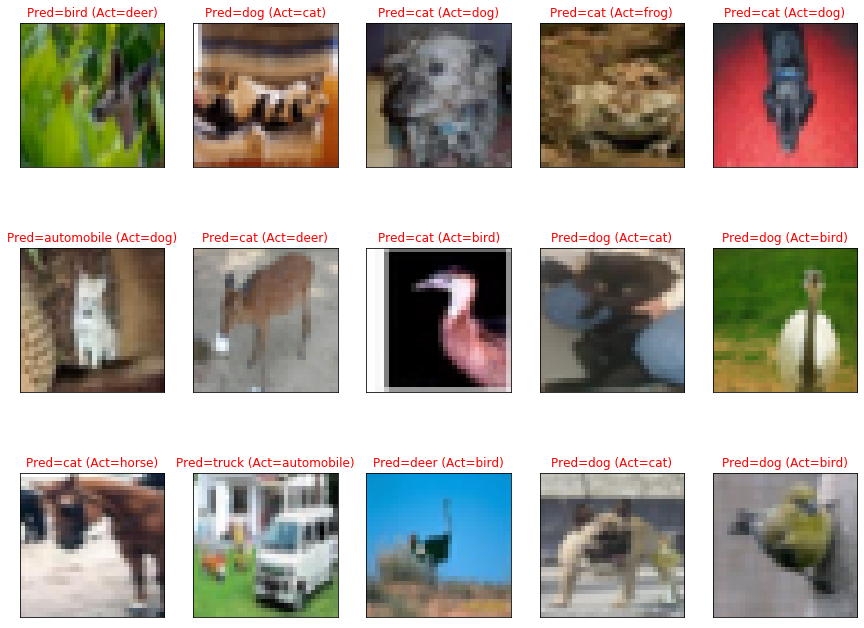

In [21]:
# obtain one batch of test images
dataiterator = iter(test_loader)
plotdata.PlotData.plotmisclassifiedimages(dataiterator=dataiterator,model=cnn_model,classes=classes,
                                          batch_size=batch_size,dogradcam=False)

In [22]:
import torch
import src.utils.utils as utils
import src.preprocessing.albumentationstransforms as preprocessing
preproc = preprocessing.AlbumentaionsTransforms()
import glob
from PIL import Image
from src.utils.modelutils import ModelUtils
import src.visualization.plotdata as plotdata

In [23]:
print(torch.cuda.is_available())
saved_data, epoch, model_state_dict, optimizer_state_dict, train_losses, train_acc, test_losses, test_acc\
            , test_losses, lr_data, class_correct, class_total\
= utils.Utils.loadmodel(path="savedmodels/finalmodelwithdata.pt")

True


In [24]:
model, device = utils.Utils.createmodelresnet18(model_state_dict=model_state_dict)

cuda


In [25]:
utils.Utils.showaccuracyacrossclasses(class_correct=class_correct,class_total=class_total)

Test Accuracy of airplane: 77% (3099/3979)
Test Accuracy of automobile: 86% (3515/4043)
Test Accuracy of  bird: 64% (2531/3914)
Test Accuracy of   cat: 56% (2253/3964)
Test Accuracy of  deer: 71% (2840/3964)
Test Accuracy of   dog: 66% (2617/3938)
Test Accuracy of  frog: 85% (3274/3813)
Test Accuracy of horse: 80% (3247/4032)
Test Accuracy of  ship: 83% (3335/3982)
Test Accuracy of truck: 84% (3288/3871)

Test Accuracy (Overall): 75% (29999/39500)


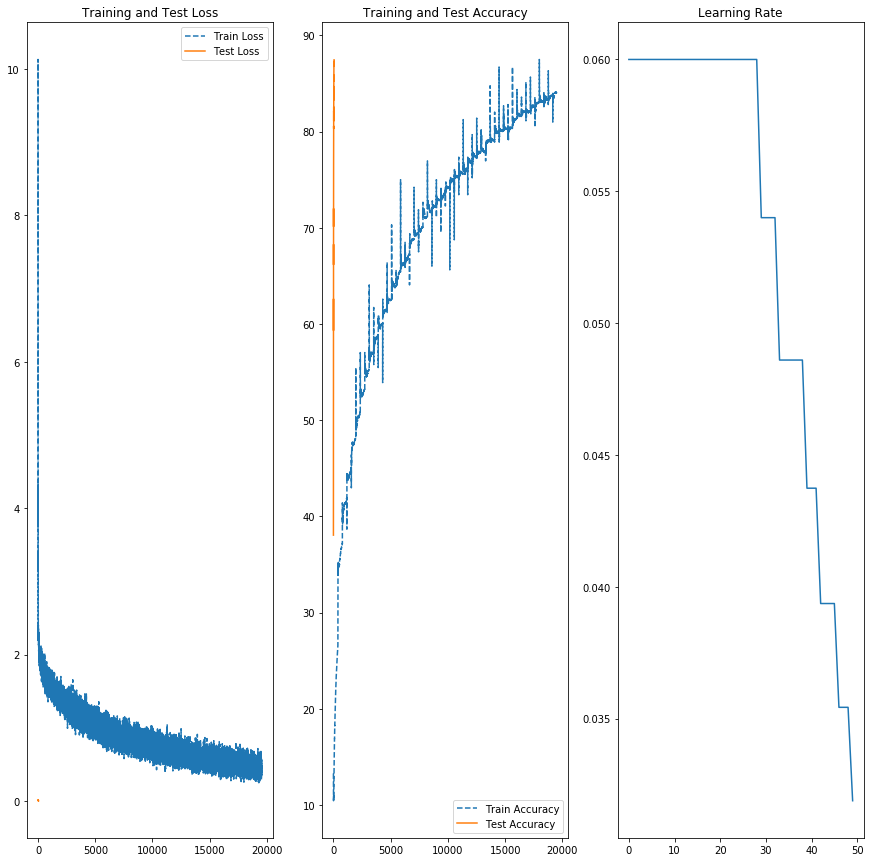

In [26]:
plotdata.PlotData.plottesttraingraph(train_losses=train_losses,train_acc=train_acc,test_losses=test_losses,
                                     test_acc=test_acc,lr_data=lr_data, plotonsamegraph=True)

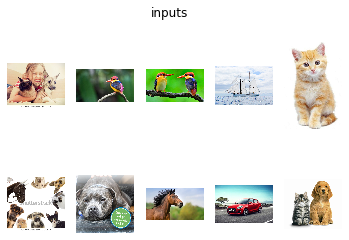

In [27]:
image_paths = glob.glob('./images/testimages/*.*')
images = list(map(lambda x: Image.open(x), image_paths))
ModelUtils.subplot(images, title='inputs', nrows=2, ncols=5)

In [28]:
import torchvision

inputs = [torchvision.transforms.Compose([torchvision.transforms.Resize((32, 32)), torchvision.transforms.ToTensor(),
                                          torchvision.transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])(
    x).unsqueeze(0) for x in images]  # add 1 dim for batch
inputs = [i.to(device) for i in inputs]

horse
bird
cat
ship
cat
cat
bird
bird
automobile
cat


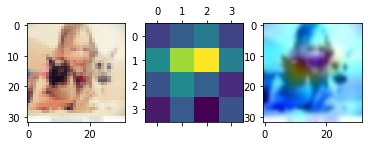

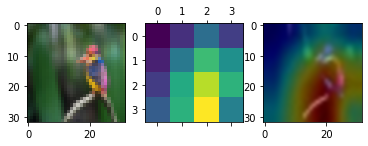

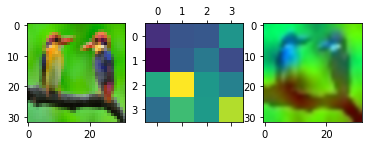

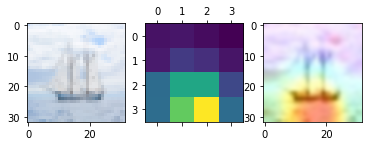

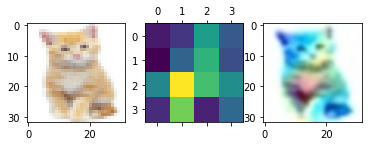

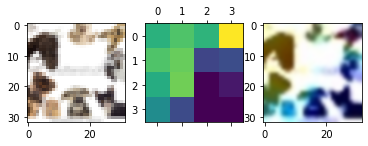

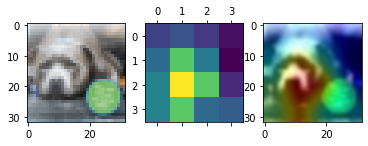

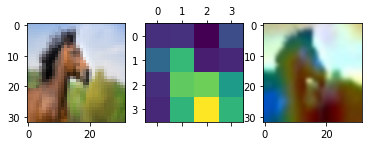

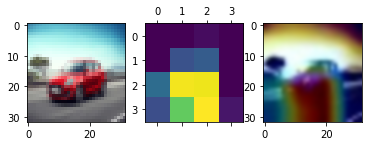

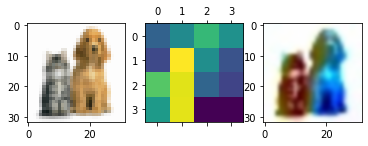

In [29]:
from src.visualization.gradcam.gradcam import gradcamof

# specify the image classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

gradcamof(model,inputs,classes)